#Unzip

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Heart/

/content/drive/MyDrive/Heart


In [ ]:
!tar -xvf "/content/drive/MyDrive/Heart/Task02_Heart.tar" -C "/content/drive/MyDrive/Heart/"

Task02_Heart/._dataset.json
Task02_Heart/dataset.json
Task02_Heart/._imagesTr
Task02_Heart/imagesTr/
Task02_Heart/imagesTr/la_007.nii.gz
Task02_Heart/imagesTr/la_019.nii.gz
Task02_Heart/imagesTr/la_023.nii.gz
Task02_Heart/imagesTr/la_005.nii.gz
Task02_Heart/imagesTr/la_009.nii.gz
Task02_Heart/imagesTr/la_017.nii.gz
Task02_Heart/imagesTr/la_021.nii.gz
Task02_Heart/imagesTr/._la_029.nii.gz
Task02_Heart/imagesTr/la_029.nii.gz
Task02_Heart/imagesTr/la_003.nii.gz
Task02_Heart/imagesTr/la_011.nii.gz
Task02_Heart/imagesTr/la_030.nii.gz
^C


In [ ]:
%cd Task02_Heart

/content/drive/MyDrive/Heart/Task02_Heart


In [ ]:
!ls

dataset.json  imagesTr	imagesTs  labelsTr  Preprocessed


#imports

In [ ]:
!pip install nibabel celluloid torchmetrics pytorch_lightning
!pip install imgaug -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.0 MB/s 
     |████████████████████████████████| 798 kB 71.6 MB/s 
     |████████████████████████████████| 125 kB 79.0 MB/s 
     |████████████████████████████████| 87 kB 8.6 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=82e0fb229eba12486c06a910cc09b3f691671a7e6524d47e791613920bc9c676
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torchmetrics
import cv2
import imgaug
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import pytorch_lightning as pl
from pathlib import Path
from tqdm.notebook import tqdm
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from celluloid import Camera
from IPython.display import HTML
from torchvision import transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


#Preprocessing

In [ ]:
root = Path('imagesTr/')
label = Path('labelsTr/')

In [ ]:
def change_img_to_lbl_path(path):
  parts = list(path.parts)
  parts[parts.index('imagesTr')] = 'labelsTr'
  return Path(*parts)

In [ ]:
sample_path = list(root.glob('la*'))[0]
sample_path_lbl = change_img_to_lbl_path(sample_path)
sample_path, sample_path_lbl

(PosixPath('imagesTr/la_003.nii.gz'), PosixPath('labelsTr/la_003.nii.gz'))

In [ ]:
data = nib.load(sample_path)
label = nib.load(sample_path_lbl)


mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

nib.aff2axcodes(data.affine)

('R', 'A', 'S')

/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.8/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


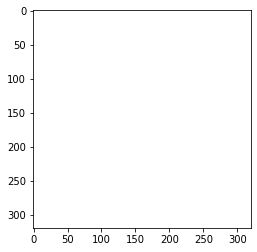

In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
  plt.imshow(mri[:,:,i], cmap="gray")
  mask_ = np.ma.masked_where(mask[:,:,i]==0 , mask[:,:,i])
  plt.imshow(mask_ , alpha = 0.6 , cmap="autumn")
  camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())

In [ ]:
def normalize(full_volume):
  mu = full_volume.mean()
  std = np.std(full_volume)
  normalized = (full_volume - mu)/std
  return normalized

def standardize(normalized):
  standardized = (normalized - normalized.min())/(normalized.max()- normalized.min())
  return standardized

In [ ]:
all_files= list(root.glob("la*"))
len(all_files)

20

In [ ]:
save_root = Path("Preprocessed")


for counter , path_to_mri_data in enumerate(tqdm(all_files)):

  path_to_lbl = change_img_to_lbl_path(path_to_mri_data)

  mri = nib.load(path_to_mri_data)
  assert nib.aff2axcodes(mri.affine) == ('R', 'A', 'S')
  mri_data = mri.get_fdata()

  lbl = nib.load(path_to_lbl)
  lbl_data = lbl.get_fdata().astype(np.uint8)

  mri_data = mri_data[32:-32,32:-32]
  lbl_data = lbl_data[32:-32,32:-32]


  normalized_mri_data = normalize(mri_data)
  standardized_mri_data = standardize(normalized_mri_data)


  if counter < 17 :
    current_path = save_root/"train"/str(counter)
  else : 
    current_path = save_root/"val"/str(counter)


  for i in range(standardized_mri_data.shape[-1]):
    slice = standardized_mri_data[:,:,i]
    mask = lbl_data[:,:,i]

    slice_path = current_path/"data"
    mask_path = current_path/"masks"
    
    slice_path.mkdir(parents=True ,exist_ok= True )
    mask_path.mkdir(parents=True ,exist_ok= True )


    np.save(slice_path/str(i), slice)
    np.save(mask_path/str(i), mask)


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
path= Path("Preprocessed/train/1")
file = '60.npy'
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

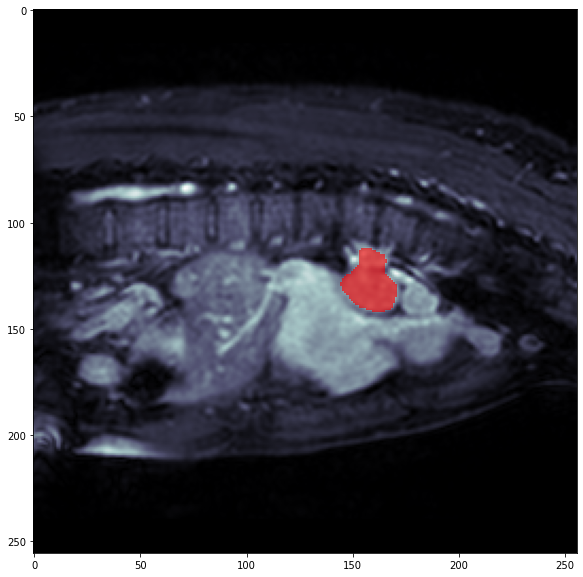

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(slice,cmap='bone')
mask_ = np.ma.masked_where(mask==0 , mask)
plt.imshow(mask_ , alpha = 0.6 , cmap='autumn')

#Dataset

In [ ]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
    
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):   
            slice_path = subject/"data"
            for slice in slice_path.glob("*"):
                files.append(slice)
        return files
    
    
    @staticmethod
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):

        random_seed = torch.randint(0, 1000000, (1,))[0].item()
        imgaug.seed(random_seed)
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        return len(self.all_files)
 
    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [ ]:
seq = iaa.Sequential([iaa.Affine(scale=(0.85 , 1.15),rotate=(-45, 45)),iaa.ElasticTransformation()])

In [ ]:
path = Path("Preprocessed/train/")
dataset = CardiacDataset(path , seq)

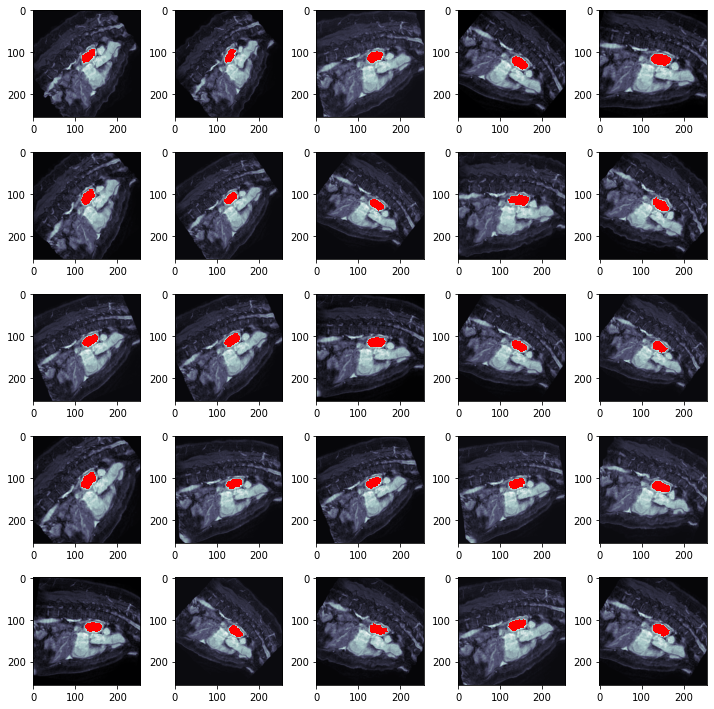

In [ ]:
fig , ax = plt.subplots(5,5,figsize=(10,10))

for i in range(5):
  for j in range(5):
    slice , mask = dataset[67]
    mask_ = np.ma.masked_where(mask==0 , mask)
    ax[i][j].imshow(slice[0] , cmap="bone")
    ax[i][j].imshow(mask_[0] , cmap="autumn")

plt.tight_layout()


#Model

In [ ]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
                                        torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)
    

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
        
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret

#Train : Load Date

In [ ]:
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)


In [ ]:
len(train_dataset)

1911

In [ ]:
len(val_dataset)

360

In [ ]:
batch_size = 8
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
class DiceLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()      
        denum = pred.sum() + mask.sum() + 1e-8  
        dice =  (2*counter)/denum
        return 1 - dice


##Article
[Dice Loss ](https://arxiv.org/pdf/2006.14822#:~:text=E.-,Dice%20Loss,2yp%2B%201)


#Train:Model

In [ ]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min')

In [ ]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=3)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

ValueError: ignored

#Evaluation

In [ ]:
model = AtriumSegmentation.load_from_checkpoint("logs/lightning_logs/version_5/checkpoints/epoch=9-step=2420.ckpt")

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [ ]:
prediction = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    prediction.append(pred.cpu().numpy())
    labels.append(label)
    
prediction = np.array(prediction)
labels = np.array(labels)

In [ ]:
model.loss_fn(torch.from_numpy(prediction), torch.from_numpy(labels))

In [ ]:
dice_score = 1-DiceLoss()(torch.from_numpy(prediction), torch.from_numpy(prediction).unsqueeze(0).float())

In [ ]:
dice_score

# Visualization

In [ ]:
%cd ..

In [ ]:
subject = Path("/content/drive/MyDrive/heart/Task02_Heart/imagesTs/la_008.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [ ]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [ ]:
standardized_scan.shape

In [ ]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slices = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slices).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

In [ ]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap="bone")
    mask = np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask, alpha=0.5)
    camera.snap()
animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_html5_video())